In [1]:
#检查TF版本，检查GPU是否正常
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.10.0
Default GPU Device: /device:GPU:0


In [2]:
#导入各种包
import numpy as np
import math
import os
import PIL
import h5py
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler,EarlyStopping
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score


Using TensorFlow backend.


In [3]:
#参数/变量
data_path = './blood_cell_data/'
epochs = 100
batch_size = 128
image_shape = (240,320,3)

In [5]:
#获取基本图片信息
def get_images_and_shapes(file_path):
    image_files = [os.path.join(file_path, file) for file in os.listdir(file_path) if file[0]!='.']
    images_shapes= []
    images_sizes =[]
    for ii, path in enumerate(image_files):
        img = image.load_img(path)
        shape = np.shape(img)
        images_shapes.append(shape)
        images_sizes.append(shape[0]*shape[1])
    print("finished")
    return image_files, images_shapes,images_sizes,len(image_files)

#生成X，Y
def get_X_y_files(data_path, image_shape):
    data_dirs = [path for path in os.listdir(data_path) if path[0]!='.']
    data_dic = dict()
    
    for path in data_dirs:
        files, shapes,sizes,count = get_images_and_shapes(os.path.join(data_path,path))
        data_dic.update({path:(files,shapes,sizes,count)})
    
    n_samples = 0
    for key,value in data_dic.items():
        n_samples += value[3]
    
    X = np.empty((n_samples, image_shape[0], image_shape[1],image_shape[2]), dtype=np.float32)
    y = np.empty((n_samples,1),dtype=np.str)
    
    files = []        
    i = 0    
    for key,value in data_dic.items():
        for ii, file in enumerate(value[0]):
            x = image.load_img(file, target_size=image_shape)
            x = image.img_to_array(x)
            x = np.expand_dims(x, axis=0)
            X[i+ii]= x
            y[i+ii]= key
        files.append(value[0])
        i += value[3]
    files = np.concatenate(files)
    
    encoder = LabelEncoder()
    encoder.fit(y)

    encoded_y = encoder.transform(y)
    encoded_y = np_utils.to_categorical(encoded_y)
    
    return X, encoded_y, files, data_dirs

#Shuffle
def get_splited_shuffled(X, encoded_y, files):
    rows = len(files)
    row_indices = np.random.permutation(rows)

    split_index = int(rows*0.9)

    X_train,X_test = X[row_indices[0:split_index],:],X[row_indices[split_index:],:]

    files_train,files_test = files[row_indices[0:split_index]],files[row_indices[split_index:]]

    encoded_y_train, encoded_y_test = encoded_y[row_indices[0:split_index],:],encoded_y[row_indices[split_index:],:]
    
    return X_train, X_test, encoded_y_train, encoded_y_test, files_train, files_test



In [6]:
#获取数据
X, y_encoded, image_files, classes = get_X_y_files(data_path, image_shape)
print("finished")

#获取训练集，测试集
X_train, X_test, encoded_y_train, encoded_y_test, files_train, files_test = get_splited_shuffled(X, y_encoded, image_files)
print("finished")
del X
del y_encoded

finished
finished
finished
finished


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


finished
finished


In [7]:
#SGD step_decay
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)

#构造模型
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(240, 320, 3), output_shape=(240, 320, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(240, 320, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))   
    model.add(Dense(64))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])

    return model
print("finished")

finished


In [8]:
#获取模型
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 318, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 318, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 318, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 159, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 157, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 117, 157, 64)      0         
__________

In [9]:
#训练模型
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
history = model.fit(X_train, encoded_y_train, batch_size=batch_size,shuffle=True, epochs=epochs, validation_split=0.2,callbacks=[early_stopping,lrate])
print("finished")

Train on 7168 samples, validate on 1793 samples
Epoch 1/100
7168/7168 [==============================] - 25s 4ms/step - loss: 1.4397 - acc: 0.4407 - val_loss: 2.2764 - val_acc: 0.3965
Epoch 2/100
7168/7168 [==============================] - 18s 3ms/step - loss: 0.7360 - acc: 0.6985 - val_loss: 1.6748 - val_acc: 0.4177
Epoch 3/100
7168/7168 [==============================] - 19s 3ms/step - loss: 0.4216 - acc: 0.8403 - val_loss: 1.3698 - val_acc: 0.5265
Epoch 4/100
7168/7168 [==============================] - 18s 3ms/step - loss: 0.2602 - acc: 0.9046 - val_loss: 0.9665 - val_acc: 0.6425
Epoch 5/100
7168/7168 [==============================] - 19s 3ms/step - loss: 0.1541 - acc: 0.9482 - val_loss: 0.4407 - val_acc: 0.8293
Epoch 6/100
7168/7168 [==============================] - 19s 3ms/step - loss: 0.0973 - acc: 0.9701 - val_loss: 0.2424 - val_acc: 0.9063
Epoch 7/100
7168/7168 [==============================] - 19s 3ms/step - loss: 0.0688 - acc: 0.9778 - val_loss: 0.1743 - val_acc: 0.9320


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


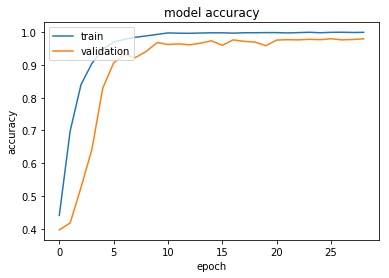

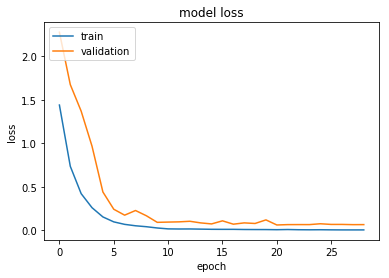

In [10]:
#可视化训练loss和acc
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
#测试集准确率
from sklearn.metrics import accuracy_score

y_pred_p = model.predict(X_test)
y_pred = np.rint(model.predict(X_test))

print(f'测试集准确率:{accuracy_score(encoded_y_test, y_pred)}')

测试集准确率:0.9728915662650602


In [12]:
#混淆矩阵
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(encoded_y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))

[[213   0   0  10]
 [  0 279   0   1]
 [  0   0 231   0]
 [ 14   2   0 246]]


In [13]:
#显示一张图片
def visualize_image(file,image_shape):
    print(f"随机抽取的测试图片路径:{file}")
    
    import matplotlib.pyplot as plt
    import PIL
    from keras.preprocessing import image
    get_ipython().magic('matplotlib inline')
    
    img = image.load_img(file, target_size=image_shape)
    img = image.img_to_array(img)
    img = img.astype(np.uint8)
    
    plt.imshow(img)

def random_predict_one_picture(classes, files_test, X_test):
    classes.sort()
    m = np.random.randint(len(files_test))
    p = model.predict(X_test[m:m+1,:])
    n = np.argmax(p, axis=1)
    visualize_image(files_test[m],(240,320))
    print(f"预测结果:{classes[n[0]]}:{p[0][n[0]]}")

随机抽取的测试图片路径:./blood_cell_data/LYMPHOCYTE/_13_9827.jpeg
预测结果:LYMPHOCYTE:0.9999933242797852


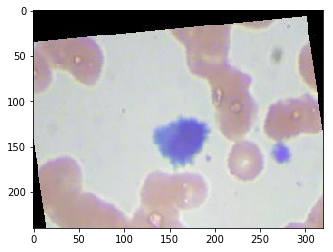

In [14]:
#从测试集中随机抽取一张图片预测
random_predict_one_picture(classes, files_test, X_test)